In [1]:
import numpy as np
import pandas as pd
from school_lp_functions import *
from school_greedy_real import * 
import pickle

# Import Data

In [9]:
schools_tanjung = pd.read_csv('schools_tanjung.csv')
schools_tanjung.rename(columns = {'Unnamed: 0': 'field_1'}, inplace = True)
distance_tanjung = pd.read_csv('tanjung_distance.csv') # distance between schools considering road

schools_gangga = pd.read_csv('schools_gangga.csv')
schools_gangga.rename(columns = {'Unnamed: 0': 'field_1'}, inplace = True)
distance_gangga = pd.read_csv('distance_gangga.csv') # distance between schools considering road

schools_pemenang = pd.read_csv('schools_pemenang.csv')
schools_pemenang.rename(columns = {'Unnamed: 0': 'field_1'}, inplace = True)
distance_pemenang = pd.read_csv('distance_pemenang.csv')

schools_gunungsari = pd.read_csv('schools_gunungsari.csv')
schools_gunungsari.rename(columns = {'Unnamed: 0': 'field_1'}, inplace = True)
distance_gunungsari = pd.read_csv('distance_gunungsari.csv') # distance between schools considering road

In [10]:
# define function to change RB, RS, RR to 3,2,1,0
values = [0,1,2,3]

conditions = [
    (schools_tanjung['damage'] == 'BAIK'),
    (schools_tanjung['damage'] == 'RR'),
    (schools_tanjung['damage'] == 'RS'),
    (schools_tanjung['damage'] == 'RB')]
schools_tanjung['damage_level'] = np.select(conditions,values)

conditions = [
    (schools_gangga['damage'] == 'BAIK'),
    (schools_gangga['damage'] == 'RR'),
    (schools_gangga['damage'] == 'RS'),
    (schools_gangga['damage'] == 'RB')]
schools_gangga['damage_level'] = np.select(conditions,values)

conditions = [
    (schools_pemenang['damage'] == 'BAIK'),
    (schools_pemenang['damage'] == 'RR'),
    (schools_pemenang['damage'] == 'RS'),
    (schools_pemenang['damage'] == 'RB')]
schools_pemenang['damage_level'] = np.select(conditions,values)

conditions = [
    (schools_gunungsari['damage'] == 'BAIK'),
    (schools_gunungsari['damage'] == 'RR'),
    (schools_gunungsari['damage'] == 'RS'),
    (schools_gunungsari['damage'] == 'RB')]
schools_gunungsari['damage_level'] = np.select(conditions,values)

In [11]:
cols = ['entry_cost', 'network_cost', 'exit_cost', 'total_cost']
distance_tanjung.loc[distance_tanjung['origin_id'] == distance_tanjung['destination_id'],cols] = 0
distance_gangga.loc[distance_gangga['origin_id'] == distance_gangga['destination_id'],cols] = 0
distance_pemenang.loc[distance_pemenang['origin_id'] == distance_pemenang['destination_id'],cols] = 0
distance_gunungsari.loc[distance_gunungsari['origin_id'] == distance_gunungsari['destination_id'],cols] = 0

# Comparison

In [12]:
schools_region = [schools_tanjung, schools_gangga, schools_pemenang, schools_gunungsari]
distances_region = [distance_tanjung, distance_gangga, distance_pemenang, distance_gunungsari]
region_names = ['Tanjung', 'Gangga', 'Pemenang', 'Gunungsari']

In [39]:
results = {}
for k in range(len(schools_region)):
# for k in range(3,4):
    
    # extract data
    print('Region: ', region_names[k])
    schools = schools_region[k]
    distance = distances_region[k]
    
    schools_id = schools['field_1'].values
    ds = schools['damage_level'].values
    demand = dict(zip(schools['field_1'], schools['total_students']))
    demand_list = schools['total_students'].values
    
    if k == 0:
        classroom = dict(zip(schools_tanjung['field_1'], schools_tanjung['classroom']))
        cons_time = dict(zip(schools['field_1'], schools['days']))
        cons_time_lp = {schools_id[i]: 3 if cons_time[schools_id[i]] == 83 else (0 if cons_time[schools_id[i]] == 0 else 1) for i in range(len(schools_id))}
    else:
        classroom = {schools_id[i]: 20 for i in range(len(schools_id))} # unlimited capacity
        cons_time = {schools_id[i]: 83 if ds[i] == 3 else (0 if ds[i] == 0 else 27) for i in range(len(schools_id))}
        cons_time_lp = {schools_id[i]: 3 if cons_time[schools_id[i]] == 83 else (0 if cons_time[schools_id[i]] == 0 else 1) for i in range(len(schools_id))}
        
    TIMES = list(range(sum(cons_time_lp.values())+1))
    
    # distance matrix for LP
    distance_matrix = {}
    for i in schools_id:
        for j in schools_id:
            dst = get_distance(i, j, distance)
            distance_matrix[i,j] = dst
    
    # run greedy
    print('Greedy')
    greedy_order, greedy_cost,_ = greedy_capacity(schools_id, ds, demand, cons_time, 
                                                classroom, distance_matrix)
    
    # run naive policies
    print('Naive Policies')
    order_demand = get_demand_order(schools_id, ds, demand_list)
    order_damage_demand = get_damage_demand_order(schools_id, ds, demand_list)
    order_time_demand = get_time_demand_order(schools_id,ds,cons_time, demand_list)
    
    cost_demand = naive_capacity(order_demand, schools_id, ds, demand, classroom, distance_matrix)
    cost_damage_demand = naive_capacity(order_damage_demand, schools_id, ds, demand, classroom, distance_matrix)
    cost_time_demand = naive_capacity(order_time_demand, schools_id, ds, demand, classroom, distance_matrix)
    
    # run relaxed LP
    print('LP')
    X = schools_id[ds!=0] # damaged schools
    S0 = schools_id[ds==0] # functional schools
    MACHINES = [1]
    B = 1000 # unlimited capacity
    m, dv,schedule = relaxed_lp(X, S0, MACHINES, TIMES, B, cons_time_lp, demand, classroom, distance_matrix, print_output = False)
    
    dict_results = {}
    for key in dv['c'].keys():
        if key[1] in dict_results:
            dict_results[key[1]] += dv['c'][key]
        else:
            dict_results[key[1]] = dv['c'][key]
            
    lists = sorted(dict_results.items())
    relaxed_lp_time,relaxed_lp_cost = zip(*lists)
    relaxed_lp_time = np.array(relaxed_lp_time)*27
    
    orders = [greedy_order, order_demand, order_damage_demand, order_time_demand]
    costs = [greedy_cost, cost_demand, cost_damage_demand, cost_time_demand]
    
    # Combine all results
    results[region_names[k]] = {'orders': orders, 'costs': costs, 'rlp_time': relaxed_lp_time, 'rlp_cost':relaxed_lp_cost}

Region:  Tanjung
Greedy
Naive Policies
LP
Region:  Gangga
Greedy
Naive Policies
LP
Region:  Pemenang
Greedy
Naive Policies
LP
Region:  Gunungsari
Greedy
Naive Policies
LP


In [57]:
# save as pickle
pickle.dump(results, open('results_greedy_simple.pkl', 'wb'))

In [2]:
results = pickle.load( open( "results_greedy_simple.pkl", "rb" ) )

Tanjung


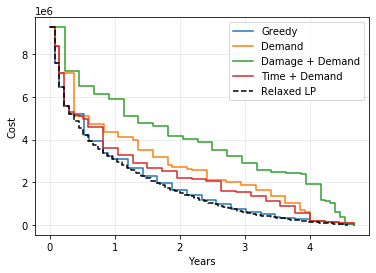

Gangga


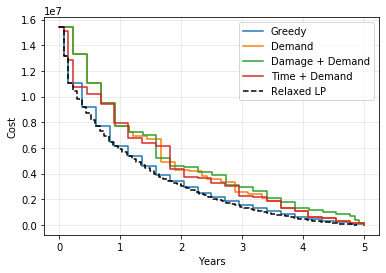

Pemenang


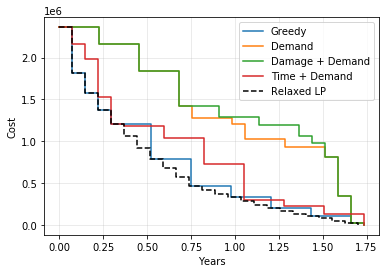

Gunungsari


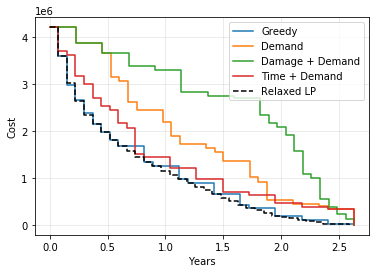

In [15]:
labels = ['Greedy','Demand', 'Damage + Demand', 'Time + Demand']
results_area = {}
for k in range(len(schools_region)):
    print(region_names[k])
    result = results[region_names[k]]
    schools = schools_region[k]
    schools_id = schools['field_1'].values
    ds = schools['damage_level'].values
    
    if k == 0:
        cons_time = dict(zip(schools['field_1'], schools['days']))
    else:
        cons_time = {schools_id[i]: 83 if ds[i] == 3 else (0 if ds[i] == 0 else 27) for i in range(len(schools_id))}
    
    plt.figure()
    results_tmp = {}
    for j in range(len(labels)):
        x_time = np.zeros(len(result['orders'][j]) + 1)
        for i in range(1, len(x_time)):
            x_time[i] = x_time[i-1] + cons_time[result['orders'][j][i-1]]

        plt.plot(x_time/365, result['costs'][j], drawstyle = 'steps-post', label = labels[j])
        results_tmp[labels[j]] = np.trapz(result['costs'][j], x_time/365)

    plt.plot(result['rlp_time']/365,result['rlp_cost'], color = 'k', drawstyle = 'steps-post', linestyle = 'dashed', label = 'Relaxed LP')
    results_tmp['Relaxed LP'] = np.trapz(result['rlp_cost'], result['rlp_time']/365)

    plt.grid(alpha = 0.3)
    plt.xlabel('Years')
    plt.ylabel('Cost')
    plt.ticklabel_format(axis = 'y', style = 'sci', scilimits = (0,0))
    plt.legend()
    plt.show()
    
    results_area[region_names[k]] = results_tmp

In [16]:
pd.DataFrame.from_dict(results_area)

,Tanjung,Gangga,Pemenang,Gunungsari
Greedy,8.462818e+06,1.650450e+07,1.053414e+06,2.722064e+06
Demand,1.234267e+07,2.242547e+07,2.284354e+06,4.748413e+06
Damage + Demand,1.794541e+07,2.352424e+07,2.385065e+06,6.768931e+06
Time + Demand,1.065456e+07,2.136774e+07,1.325262e+06,3.436288e+06
Relaxed LP,8.308461e+06,1.615419e+07,1.039738e+06,2.696469e+06
